## libs

In [1]:
# python utils
import itertools
import inspect

# pre-processing and exploring data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# model building
from minisom import MiniSom 

## Import Data

In [4]:
df = pd.read_csv('../datasets/breast_cancer_wisconsin.csv', header=0).drop('id', axis=1).drop('Unnamed: 32', axis=1)
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Preprocessing Data

In [5]:
df['diagnosis'] = df['diagnosis'].factorize()[0]
df['diagnosis'] = df['diagnosis'].astype("category")
df.dtypes

diagnosis                  category
radius_mean                 float64
texture_mean                float64
perimeter_mean              float64
area_mean                   float64
smoothness_mean             float64
compactness_mean            float64
concavity_mean              float64
concave points_mean         float64
symmetry_mean               float64
fractal_dimension_mean      float64
radius_se                   float64
texture_se                  float64
perimeter_se                float64
area_se                     float64
smoothness_se               float64
compactness_se              float64
concavity_se                float64
concave points_se           float64
symmetry_se                 float64
fractal_dimension_se        float64
radius_worst                float64
texture_worst               float64
perimeter_worst             float64
area_worst                  float64
smoothness_worst            float64
compactness_worst           float64
concavity_worst             

In [6]:
# split in input and output sets
input_df = df.drop("diagnosis", axis=1)
output_df = df["diagnosis"]

In [7]:
# normalizing values of input df between 0 and 1 (per column)
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

input_df = normalize(input_df)
input_df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,0.605518,...,0.620776,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864
1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323,...,0.606901,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878
2,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,0.211247,...,0.556386,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433
3,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,1.000000,...,0.248310,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711
4,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,0.186816,...,0.519744,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595


In [8]:
# minsisom lib expects input_data as numpy matrix not pandas, converting...
input_data = input_df.values
input_data

array([[0.52103744, 0.0226581 , 0.54598853, ..., 0.91202749, 0.59846245,
        0.41886396],
       [0.64314449, 0.27257355, 0.61578329, ..., 0.63917526, 0.23358959,
        0.22287813],
       [0.60149557, 0.3902604 , 0.59574321, ..., 0.83505155, 0.40370589,
        0.21343303],
       ...,
       [0.45525108, 0.62123774, 0.44578813, ..., 0.48728522, 0.12872068,
        0.1519087 ],
       [0.64456434, 0.66351031, 0.66553797, ..., 0.91065292, 0.49714173,
        0.45231536],
       [0.03686876, 0.50152181, 0.02853984, ..., 0.        , 0.25744136,
        0.10068215]])

## Model builder

In [9]:
def build_som_model(size, input_len, sigma, learning_rate):
    return MiniSom(size, size, input_len, sigma=sigma, learning_rate=learning_rate, 
                   neighborhood_function='bubble', random_seed=10)

def build_models(builder_method, *args_tests):
    """
    Build models with all the combinations of the args_test passed
    """
    builder_args_names = list(inspect.signature(builder_method).parameters.keys())
    return [
        dict((("model", builder_method(*args)),) + tuple(zip(builder_args_names, args)))
        for args in itertools.product(*args_tests)
    ]

## Models Definition

In [13]:
# Parameters definition

# fixed
input_len = [30]
size_tests = [32]

# tests
sigma_tests = [10, 5, 3, 1]
learning_rate_tests = [5, 1, 0.1, 0.01]

In [14]:
# building models with all the combinations of the test parameters
models = build_models(
    build_som_model,
    size_tests,
    input_len,
    sigma_tests,
    learning_rate_tests,
)
models

[{'model': <minisom.MiniSom at 0x7fa443799950>,
  'size': 32,
  'input_len': 30,
  'sigma': 10,
  'learning_rate': 5},
 {'model': <minisom.MiniSom at 0x7fa443b52550>,
  'size': 32,
  'input_len': 30,
  'sigma': 10,
  'learning_rate': 1},
 {'model': <minisom.MiniSom at 0x7fa443788e50>,
  'size': 32,
  'input_len': 30,
  'sigma': 10,
  'learning_rate': 0.1},
 {'model': <minisom.MiniSom at 0x7fa443788cd0>,
  'size': 32,
  'input_len': 30,
  'sigma': 10,
  'learning_rate': 0.01},
 {'model': <minisom.MiniSom at 0x7fa443788fd0>,
  'size': 32,
  'input_len': 30,
  'sigma': 5,
  'learning_rate': 5},
 {'model': <minisom.MiniSom at 0x7fa443788e10>,
  'size': 32,
  'input_len': 30,
  'sigma': 5,
  'learning_rate': 1},
 {'model': <minisom.MiniSom at 0x7fa4437887d0>,
  'size': 32,
  'input_len': 30,
  'sigma': 5,
  'learning_rate': 0.1},
 {'model': <minisom.MiniSom at 0x7fa47e235150>,
  'size': 32,
  'input_len': 30,
  'sigma': 5,
  'learning_rate': 0.01},
 {'model': <minisom.MiniSom at 0x7fa443799

## Models Training

In [15]:
for model in models:
    model['model'].pca_weights_init(input_data)
    model['model'].train_batch(input_data, 10000, verbose=False)
    model['quantization_error'] = model['model'].quantization_error(input_data)
    model['topographic_error'] = model['model'].topographic_error(input_data)

/home/rafaelpereira/anaconda3/envs/tensorflow/lib/python3.7/site-packages/numpy/linalg/linalg.py:2513: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))
/home/rafaelpereira/anaconda3/envs/tensorflow/lib/python3.7/site-packages/numpy/linalg/linalg.py:2512: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
/home/rafaelpereira/anaconda3/envs/tensorflow/lib/python3.7/site-packages/minisom.py:258: RuntimeWarning: invalid value encountered in add
  self._weights += einsum('ij, ijk->ijk', g, x-self._weights)


In [16]:
models

[{'model': <minisom.MiniSom at 0x7fa443799950>,
  'size': 32,
  'input_len': 30,
  'sigma': 10,
  'learning_rate': 5,
  'quantization_error': nan,
  'topographic_error': 1.0},
 {'model': <minisom.MiniSom at 0x7fa443b52550>,
  'size': 32,
  'input_len': 30,
  'sigma': 10,
  'learning_rate': 1,
  'quantization_error': 0.3160103566917308,
  'topographic_error': 0.9964850615114236},
 {'model': <minisom.MiniSom at 0x7fa443788e50>,
  'size': 32,
  'input_len': 30,
  'sigma': 10,
  'learning_rate': 0.1,
  'quantization_error': 0.30974255788835336,
  'topographic_error': 0.9261862917398945},
 {'model': <minisom.MiniSom at 0x7fa443788cd0>,
  'size': 32,
  'input_len': 30,
  'sigma': 10,
  'learning_rate': 0.01,
  'quantization_error': 0.357308091705469,
  'topographic_error': 0.9982425307557118},
 {'model': <minisom.MiniSom at 0x7fa443788fd0>,
  'size': 32,
  'input_len': 30,
  'sigma': 5,
  'learning_rate': 5,
  'quantization_error': 0.8032847599334756,
  'topographic_error': 1.0},
 {'model': 

# Results

### Top Models

In [17]:
# Sorting models by topographic_error
for i, model in enumerate(sorted(models, key=lambda d: d['topographic_error'], reverse=False)):
    print("TOP {}:".format(i + 1))
    print("    quantization error: {}".format(model["quantization_error"]))
    print("    topographic error: {}".format(model["topographic_error"]))
    print("    map size (NxN): {}".format(model["size"]))
    print("    sigma: {}".format(model["sigma"]))
    print("    learning_rate: {}".format(model["learning_rate"]))
    print()

TOP 1:
    quantization error: 0.2030619474547579
    topographic error: 0.9156414762741653
    map size (NxN): 32
    sigma: 5
    learning_rate: 1

TOP 2:
    quantization error: 0.30974255788835336
    topographic error: 0.9261862917398945
    map size (NxN): 32
    sigma: 10
    learning_rate: 0.1

TOP 3:
    quantization error: 0.20147844638697243
    topographic error: 0.9525483304042179
    map size (NxN): 32
    sigma: 3
    learning_rate: 1

TOP 4:
    quantization error: 0.29848522170949676
    topographic error: 0.9595782073813708
    map size (NxN): 32
    sigma: 3
    learning_rate: 0.1

TOP 5:
    quantization error: 0.3561166178245125
    topographic error: 0.9666080843585237
    map size (NxN): 32
    sigma: 3
    learning_rate: 0.01

TOP 6:
    quantization error: 0.3516672571686962
    topographic error: 0.968365553602812
    map size (NxN): 32
    sigma: 5
    learning_rate: 0.01

TOP 7:
    quantization error: 0.440789290502846
    topographic error: 0.9683655536028

# Analysis (using the Top 1 model)

In [18]:
model = [model for model in models if model["sigma"] == 5 and model["learning_rate"] == 1][0]

In [19]:
model

{'model': <minisom.MiniSom at 0x7fa443788e10>,
 'size': 32,
 'input_len': 30,
 'sigma': 5,
 'learning_rate': 1,
 'quantization_error': 0.2030619474547579,
 'topographic_error': 0.9156414762741653}

## U-Matrix

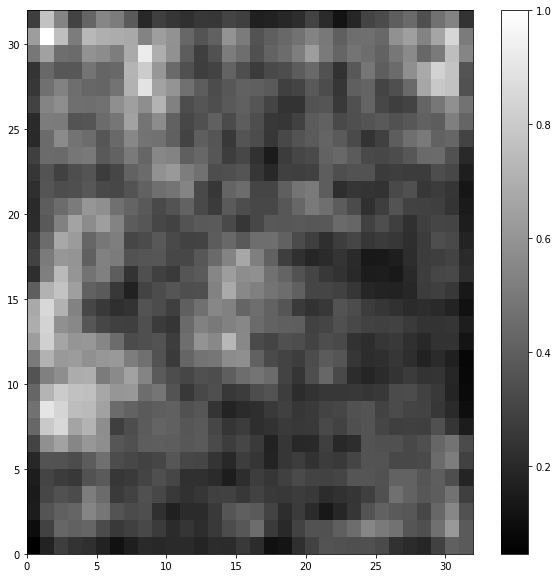

In [24]:
plt.figure(figsize=(10, 10))
plt.pcolor(model['model'].distance_map().T, cmap='gray')
plt.colorbar()

Gray scale represent the calculated distances (normalized between 0 and 1). Black nodes represents nodes very close to its neighbors, and the white ones are nodes with a avg distance between its neighbors very high.

## U-Matrix with the classes plotted

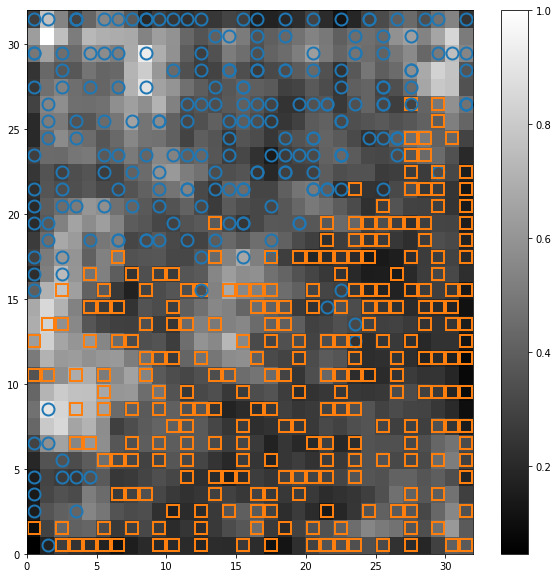

In [26]:
plt.figure(figsize=(10, 10))
plt.pcolor(model['model'].distance_map().T, cmap='gray')  # plotting the distance map as background
plt.colorbar()

target_values = output_df.values
markers = ['o', 's']
colors = ['C0', 'C1']
for cnt, xx in enumerate(input_data):
    w = model['model'].winner(xx)  # getting the winner
    plt.plot(w[0]+.5, w[1]+.5, markers[target_values[cnt]], markerfacecolor='None',
             markeredgecolor=colors[target_values[cnt]], markersize=12, markeredgewidth=2)
plt.axis([0, 32, 0, 32])
plt.show()

We can see crearly the separation between the classes. There are some confusions, but overrall it's a good clustering of the examples

# Hit Map

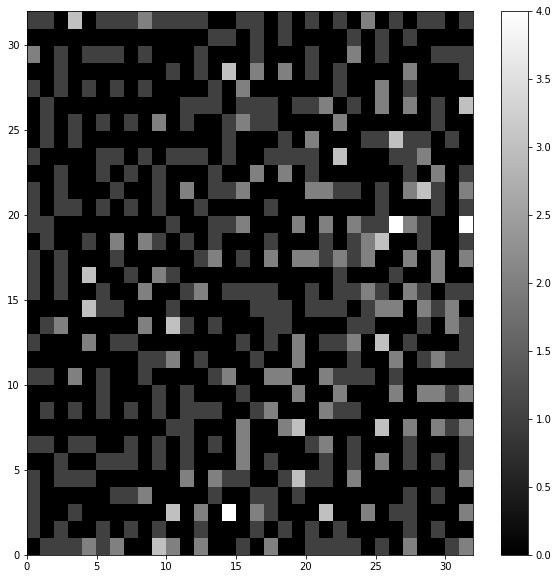

In [22]:
plt.figure(figsize=(10, 10))
frequencies = model['model'].activation_response(input_data)
plt.pcolor(frequencies.T, cmap='gray') 
plt.colorbar()
plt.show()